# Final Project - Group M

Team Members:
1. Akshay Augustine Sheby - 5123774
2. Krishnapriya Krishnan Santhadevi - 5123779
3. Megha Eldho - 5123773
4. Ranjitha Umesh - 5123734

# CNN model 

In [1]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# 1. Prepare the data
# Load input features from CSV file

file_path = 'Kaggle competition dataset/data_full_+1_-1.csv'
datasets = pd.read_csv(file_path)
print(datasets)

        Unnamed: 0  AccelX_5  AccelY_5  AccelZ_5   GyroX_5   GyroY_5   
0                0  1.370639  3.077730 -9.138201  0.026021 -0.025069  \
1                1  1.380689  3.039416 -9.200333  0.038649 -0.038450   
2                2  1.378264  2.981465 -9.305405  0.043459 -0.038100   
3                3  1.423814  2.944719 -9.343213  0.042548 -0.028578   
4                4  1.422443  2.946009 -9.392369  0.027376 -0.014168   
...            ...       ...       ...       ...       ...       ...   
722577      722577 -0.572854  7.180082  6.513024  0.001732  0.005325   
722578      722578 -0.538156  7.221120  6.618960  0.001231  0.003183   
722579      722579 -0.520193  7.248638  6.627628  0.001357  0.013642   
722580      722580 -0.527089  7.316613  6.646155  0.008508  0.025486   
722581      722581 -0.503076  7.346765  6.589603  0.011767  0.025111   

         GyroZ_5  start_step_labels  end_step_labels  
0       0.026772                0.0              0.0  
1       0.035676         

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd

# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert input features and labels to PyTorch tensors
X = torch.tensor(datasets.values[:,1:7], dtype=torch.float64)
y = torch.tensor(datasets.values[:,7:9], dtype=torch.int64)
print(X)
print(y) 

# 2. Create a CNN model
    
class CNNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(CNNModel, self).__init__()
        self.num_layers = len(hidden_sizes)
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv1d(input_size, hidden_sizes[0], kernel_size=3, padding=1))
        for i in range(self.num_layers - 1):
            self.conv_layers.append(nn.Conv1d(hidden_sizes[i], hidden_sizes[i+1], kernel_size=3, padding=1))
        self.fc = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Reshape to (batch_size, 1, input_size)
        x = x.permute(0, 2, 1)  # Adjust input shape for CNN
        output = x
        for i in range(self.num_layers):
            output = self.conv_layers[i](output)
        output = output.squeeze(2)  # Remove the sequence length dimension
        output = self.fc(output)
        return output
    
# 3. Set hyperparameters and initialize the model
input_size = 6
hidden_sizes = [64, 32, 16, 8]
output_size = 2  # 0 or 1
learning_rate = 0.01
batch_size = 64
num_epochs = 10

# Create the model and move it to the specified device
model = CNNModel(input_size, hidden_sizes, output_size).to(device)

model.to(torch.float64) #ensures that the data type of the model's parameters matches the data type of your input features

# Move the input features and labels to the specified device
X = X.to(device)
y = y.to(device)

tensor([[ 1.3706e+00,  3.0777e+00, -9.1382e+00,  2.6021e-02, -2.5069e-02,
          2.6772e-02],
        [ 1.3807e+00,  3.0394e+00, -9.2003e+00,  3.8649e-02, -3.8450e-02,
          3.5676e-02],
        [ 1.3783e+00,  2.9815e+00, -9.3054e+00,  4.3459e-02, -3.8100e-02,
          3.1424e-02],
        ...,
        [-5.2019e-01,  7.2486e+00,  6.6276e+00,  1.3570e-03,  1.3642e-02,
          9.6370e-03],
        [-5.2709e-01,  7.3166e+00,  6.6462e+00,  8.5080e-03,  2.5486e-02,
          7.4950e-03],
        [-5.0308e-01,  7.3468e+00,  6.5896e+00,  1.1767e-02,  2.5111e-02,
          7.8240e-03]], dtype=torch.float64)
tensor([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]])


In [4]:
# Create a data loader
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 4. Training loop

train_accuracy_list = []
train_loss_list = []

#Iterate over the specified number of epochs
for epoch in range(num_epochs):
    #Initialize variables for tracking loss and accuracy
    train_loss = 0.0
    correct = 0
    total = 0
    #Data is iterated through the data loader in batches
    for inputs, targets in dataloader: #batch inputs and targets
        #Convert inputs and targets to appropriate data types
        inputs = inputs.to(device) #shape: [64, 6] [batch_size, num_inp_features]
        targets = targets.to(device) #shape: [64] [batch_size]

        #Perform forward pass through the model
        outputs = model(inputs) #shape: [64, 2] [batch_size, num_of_classes]
        
        # Calculate loss
        start_pred = outputs[:, 0]
        end_pred = outputs[:, 1]
        
        start_target = targets[:, 0]
        end_target = targets[:, 1]
        
        # Convert the outputs to float tensor
        start_pred = start_pred.float()
        end_pred = end_pred.float()
        
        # Convert the targets to long (integer) tensor
        start_target = start_target.float()
        end_target = end_target.float()
        
        #Calculate the loss using loss function
        start_loss = criterion(start_pred, start_target)
        end_loss = criterion(end_pred, end_target)

        #Clear the gradients before backward pass, it ensures that the gradients from previous iterations are cleared before calculating new gradients
        optimizer.zero_grad()
        
        #Perform a single backward pass by taking average of start step loss and end step loss
        loss = (start_loss + end_loss) / 2
        loss.backward()
        
        #Update the neural network parameters based on the gradients
        optimizer.step()

        #Update training loss
        train_loss += loss.item() * inputs.size(0)
        
        #Make sure the outputs have appropriate shape and are in the range of [0, 1] using a sigmoid activation function
        start_pred = torch.sigmoid(start_pred)
        end_pred = torch.sigmoid(end_pred)
        
        start_pred = start_pred.round()
        end_pred = end_pred.round()

        #Update training accuracy     
        total += start_target.size(0)
        total += end_target.size(0)
        
        correct += (start_pred == start_target).sum().item()  
        correct += (end_pred == end_target).sum().item()

    #Calculate average training loss
    train_loss = train_loss / len(dataset)
    
    #Calculate average training accuracy
    train_accuracy = correct / total
    
    #Append the training loss and accuracy to seperate lists to plot the graph
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Print the training loss and accuracy for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100}")

Epoch [1/10], Train Loss: 13.7419, Train Accuracy: 23.78712727413636
Epoch [2/10], Train Loss: 13.7160, Train Accuracy: 40.61968053452757
Epoch [3/10], Train Loss: 13.7221, Train Accuracy: 31.855208128627616
Epoch [4/10], Train Loss: 13.6930, Train Accuracy: 16.11339612666798
Epoch [5/10], Train Loss: 13.6923, Train Accuracy: 13.882922630234354
Epoch [6/10], Train Loss: 13.7021, Train Accuracy: 47.97296362212178
Epoch [7/10], Train Loss: 13.6982, Train Accuracy: 48.93970511305291
Epoch [8/10], Train Loss: 13.7038, Train Accuracy: 49.66792696192266
Epoch [9/10], Train Loss: 13.7190, Train Accuracy: 63.73477335444282
Epoch [10/10], Train Loss: 13.6956, Train Accuracy: 62.47498553797355


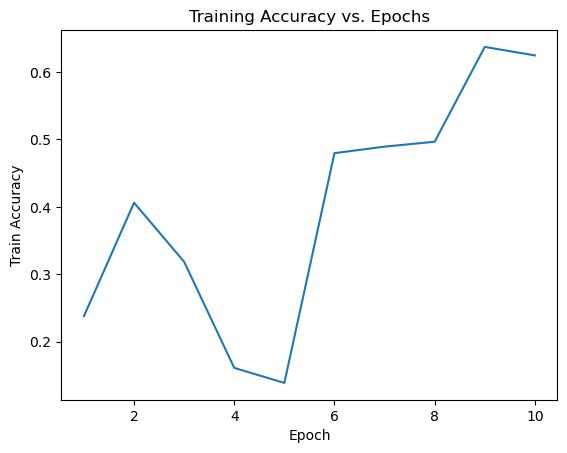

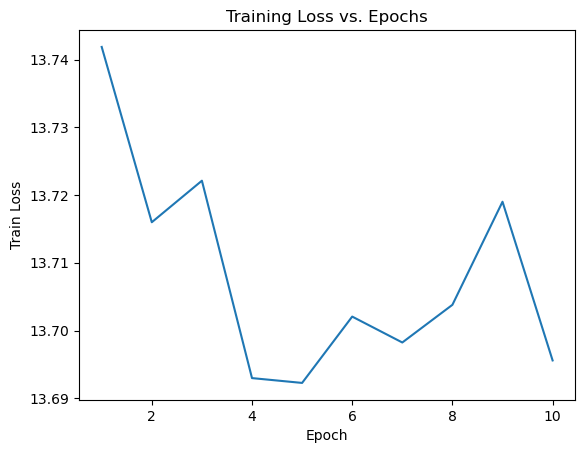

In [5]:
# 5. Visualization

#Plot the training accuracy graph
plt.plot(range(1, num_epochs+1), train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.show()

#Plot the training loss graph
plt.plot(range(1, num_epochs+1), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss vs. Epochs')
plt.show()

In [6]:
# 6. Test Data and Prediction

df_test_data = pd.read_csv("testdata.csv")
print(df_test_data)

         AccelX_5   AccelY_5   AccelZ_5   GyroX_5   GyroY_5   GyroZ_5
0       -0.833114   1.527048   9.118425  0.444920 -0.260176 -0.003165
1       -0.815806   1.547072   8.985757  0.455710 -0.386227  0.005471
2       -0.789316   1.577158   8.868717  0.417351 -0.415063  0.010528
3       -0.788688   1.586534   8.820272  0.346842 -0.376392  0.001030
4       -0.753974   1.617062   8.872701  0.247663 -0.293129 -0.025673
...           ...        ...        ...       ...       ...       ...
102086   1.392287   2.759108   9.623958 -0.024455 -0.000656 -0.029730
102087   1.385025   2.779560   9.522044 -0.017631 -0.014672 -0.031067
102088   1.349389   2.832777   9.414036 -0.014150 -0.012979 -0.031182
102089   1.361006   2.788755   9.381688 -0.009818 -0.008524 -0.029036
102090   1.330699   2.826024   9.414694 -0.010036 -0.007038 -0.025448

[102091 rows x 6 columns]


In [7]:
#Prediction
#Convert the test data to a PyTorch tensor
test_inputs = torch.tensor(df_test_data.values, dtype=torch.float64)

#Move the test inputs to the specified device
test_inputs = test_inputs.to(device)

#Set the model to evaluation mode
model.eval()

#Perform forward pass on the test data and obtain predictions for start step and end step probabilities
with torch.no_grad():
    out = model(test_inputs)
    print(out)
    start_prob = out[:, 0]
    end_prob = out[:, 1]
    start_prob = torch.sigmoid(start_prob)
    end_prob = torch.sigmoid(end_prob)

print(len(out))

tensor([[-5.4662, -0.0178],
        [-5.4946, -0.0484],
        [-5.5031, -0.0574],
        ...,
        [-5.2618,  0.2078],
        [-5.2698,  0.1992],
        [-5.2626,  0.2069]], dtype=torch.float64)
102091


In [9]:
outputs = pd.DataFrame({'index': range(len(test_inputs)), 'start': start_prob.round(), 'end': end_prob.round()})

# Save the predictions to a CSV file
outputs.to_csv('output7_cnn_4.csv', index=False)
print(outputs)

         index  start  end
0            0    0.0  0.0
1            1    0.0  0.0
2            2    0.0  0.0
3            3    0.0  0.0
4            4    0.0  0.0
...        ...    ...  ...
102086  102086    0.0  1.0
102087  102087    0.0  1.0
102088  102088    0.0  1.0
102089  102089    0.0  1.0
102090  102090    0.0  1.0

[102091 rows x 3 columns]
